In [1]:
# import python libraries
import numpy as np, pandas as pd, geopandas as gpd, matplotlib.pyplot as plt
import geopy.distance, folium

In [2]:
# WWTPs (wastewater treatment plants) data
wwtps = pd.read_excel('WWTPs.xlsx', 'datasheet')
wwtps = gpd.GeoDataFrame(wwtps, crs='EPSG:4269',
                      geometry=gpd.points_from_xy(x=wwtps.Longitude,
                                                  y=wwtps.Latitude))

In [3]:
# oil refineries data
refinery = pd.read_excel('refineries.xlsx')
refinery = gpd.GeoDataFrame(refinery, crs='EPSG:4269',
                            geometry=gpd.points_from_xy(x=refinery.Longitude,
                                                        y=refinery.Latitude))

In [4]:
# US data
US = gpd.read_file('US_data/cb_2018_us_state_500k.shp')
US = US[['NAME', 'geometry']]

# just include the conterminous US
for excluded in ('Alaska',
                 'Hawaii',
                 'Puerto Rico',
                 'American Samoa',
                 'Commonwealth of the Northern Mariana Islands',
                 'Guam',
                 'United States Virgin Islands'):
    US = US.loc[US['NAME'] != excluded]

In [5]:
# change crs to 3857 (unit: m)
wwtps = wwtps.to_crs(crs='EPSG:3857')
refinery = refinery.to_crs(crs='EPSG:3857')
US = US.to_crs(crs='EPSG:3857')

In [6]:
# spatial join of data to select out WWTPs and refineries that are in the conterminous US
wwtps = gpd.sjoin(wwtps, US)
wwtps = wwtps.drop(['index_right'], axis=1)
refinery = gpd.sjoin(refinery, US)
refinery = refinery.drop(['index_right'], axis=1)

<AxesSubplot:>

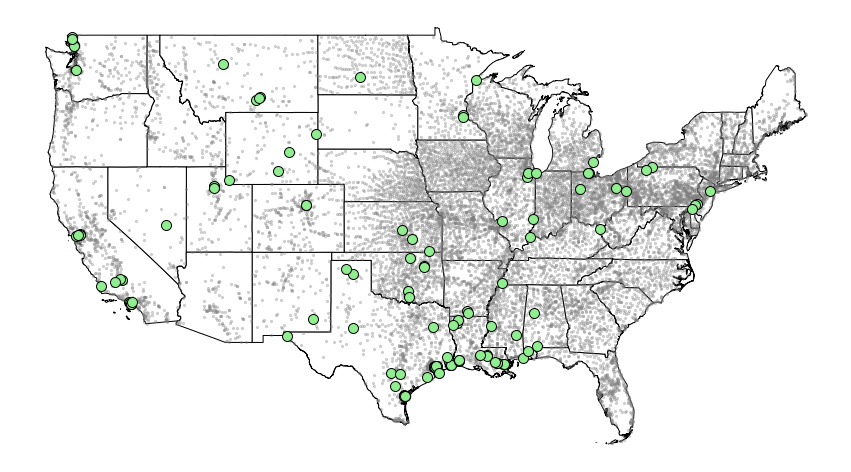

In [7]:
# basic visualization
fig, ax = plt.subplots(figsize=(15,15))
ax.tick_params(top=False, bottom=False, left=False, right=False,
               labelleft=False, labelbottom=False) # remove ticks
ax.set_frame_on(False) # remove frame

US.plot(ax=ax, color='w', edgecolor='k')
wwtps.plot(ax=ax, color='gray', alpha=0.3, markersize=5) # WWTPs shown as small gray dots
refinery.plot(ax=ax, color='lightgreen', markersize=100, edgecolor='k', linewidth=1)
# refineries shown as large green dots

In [8]:
# select out WWTPs that are within 100 km of refineries, one WWTP is only assigned once to its nearest refinery
# Since crs 3857 is not accurate at all in terms of distance calculation, especially more far away from the equator,
# I used a larger distance limits (150 km) as the max_distance in sjoin_nearest
# and then used geopy.distance.geodesic to recalculate the distance and filter out those that are actually longer than 100000

wwtps_within = wwtps.sjoin_nearest(refinery, max_distance=150000, distance_col='distance')
wwtps_within['WWTP_location'] = list(zip(wwtps_within.Latitude_left, wwtps_within.Longitude_left))
wwtps_within['refinery_location'] = list(zip(wwtps_within.Latitude_right, wwtps_within.Longitude_right))

linear_distance = []
for i in range(len(wwtps_within)):
    linear_distance.append(geopy.distance.geodesic(wwtps_within['WWTP_location'].iloc[i], wwtps_within['refinery_location'].iloc[i]).km)

wwtps_within['linear_distance'] = linear_distance

wwtps_within = wwtps_within[wwtps_within['linear_distance'] <= 100] # select out WWTPs that are within 100 km of refineries

In [9]:
wwtps_within.head()

,FACILITY,ST,CITY,Latitude_left,Longitude_left,Influent Flow (MMGal/d),Influent Flow (ML/d),BASELINE:Process Code,FUTURE:Process Code,BASELINE:ENERGY (MJ/y):Facility Influent,...,Source,Period,Latitude_right,Longitude_right,Link_Imports,NAME_right,distance,WWTP_location,refinery_location,linear_distance
0,Stickney Treatment Plant MWRDGC,IL,CICERO,41.8139,-87.7704,812.00,3073.752920,P1,P1,5.582980e+09,...,"Form EIA-820, Annual Refinery Report","As of January 1, 2022",41.655625,-88.04655,1.0,Illinois,38761.656743,"(41.8139, -87.7704)","(41.655625, -88.04655)",28.928106
202,JOHN E EGAN WRP,IL,SCHAUMBURG,42.0194,-88.0387,27.00,102.206070,E1,CEPT-OPT/1,1.856410e+08,...,"Form EIA-820, Annual Refinery Report","As of January 1, 2022",41.655625,-88.04655,1.0,Illinois,54360.420942,"(42.0194, -88.0387)","(41.655625, -88.04655)",40.409797
208,JAMES C. KIRIE WRP,IL,CHICAGO,42.0228,-87.9351,26.00,98.420660,B1,CEPT/B1,1.787654e+08,...,"Form EIA-820, Annual Refinery Report","As of January 1, 2022",41.655625,-88.04655,1.0,Illinois,56248.174031,"(42.0228, -87.9351)","(41.655625, -88.04655)",41.819570
220,FOX METRO WATER RECLAMATION DISTRICT,IL,OSWEGO,41.7156,-88.3529,24.50,92.742545,B1,CEPT/B1,1.684520e+08,...,"Form EIA-820, Annual Refinery Report","As of January 1, 2022",41.655625,-88.04655,1.0,Illinois,35255.046352,"(41.7156, -88.3529)","(41.655625, -88.04655)",26.361361
234,NAPERVILLE,IL,NAPERVILLE,41.7011,-88.1667,23.03,87.177992,G7,CEPT-OPT/1,1.583449e+08,...,"Form EIA-820, Annual Refinery Report","As of January 1, 2022",41.655625,-88.04655,1.0,Illinois,14994.330821,"(41.7011, -88.1667)","(41.655625, -88.04655)",11.207145


In [10]:
# for every refinery: calculate the capacity of WWTPs (in MGD, million gallon per day) in its neighboring region,
# with the buffering distance increasing 1 km each step from 0 to 100 km.

result = wwtps_within[['site_id']].drop_duplicates() # get the site_id of all refineries and remove duplicates

for distance in np.linspace(0, 100, 101):
    wwtps_within_distance = wwtps_within[wwtps_within['linear_distance']<=distance] # select out WWTPs that are within certain distance
    wwtps_within_distance = wwtps_within_distance.groupby('site_id').sum('Influent Flow (MMGal/d)') # sum WWTPs capacity based on their assigned refineries
    wwtps_within_distance = wwtps_within_distance[['Influent Flow (MMGal/d)']]
    wwtps_within_distance = wwtps_within_distance.rename(columns={'Influent Flow (MMGal/d)': int(distance)}) # use the corresponding distance as column name
    wwtps_within_distance.reset_index(inplace=True)
    if len(wwtps_within_distance) > 0:
        result = result.merge(wwtps_within_distance, how='left', on='site_id') # merge the result at one distance to the final result

result = result.fillna(0) # fill NA/NAN with 0

In [11]:
# some refineries don't have WWTPs assigned to them, so the length of result can be smaller than that of refinery
# for those refineries, the values from 0 km to 100 km should be all 0
if len(result) < len(refinery):
    result_index = pd.Index(result.site_id)
    refinery_index = pd.Index(refinery.site_id)
    refineries_left_id = refinery_index.difference(result_index).values
    
result = result.set_index('site_id')
for item in refineries_left_id:
    result.loc[item] = [0]*len(result.columns)

In [12]:
result.head()

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
site_id,,,,,,,,,,,,,,,,,,,,,
526,0.0,0.00,6.00,6.00,7.66,7.66,8.19,10.23,16.58,28.58,...,1214.691,1215.561,1215.561,1215.939,1221.259,1221.259,1222.932,1222.932,1222.932,1224.652
297,0.0,0.00,0.00,0.00,0.00,42.00,42.00,42.00,42.00,42.00,...,656.160,656.260,656.260,656.260,656.260,657.260,664.470,664.470,664.720,664.720
275,0.0,0.00,4.06,4.06,4.06,7.41,15.83,15.83,15.83,15.83,...,474.917,476.680,477.793,478.373,478.498,478.768,479.368,480.143,480.143,480.143
227,0.0,0.75,0.75,1.45,1.45,8.29,8.29,8.29,8.29,8.29,...,73.409,73.409,73.549,74.009,74.009,74.139,74.139,74.339,74.389,74.599
531,0.0,0.00,1.66,1.66,1.66,1.66,1.66,1.66,1.66,1.66,...,63.275,63.835,63.835,63.835,64.585,66.335,66.335,67.035,69.396,70.146


In [13]:
# add the refinery informaton to result
result = result.merge(refinery, how='left', on='site_id')

In [14]:
# group the result based on the location of refineries
PADD_1 = result[result['PADD']==1] # East Coast
PADD_2 = result[result['PADD']==2] # Midwest
PADD_3 = result[result['PADD']==3] # Gulf Coast
PADD_4 = result[result['PADD']==4] # Rocky Mountains
PADD_5 = result[result['PADD']==5] # West Coast

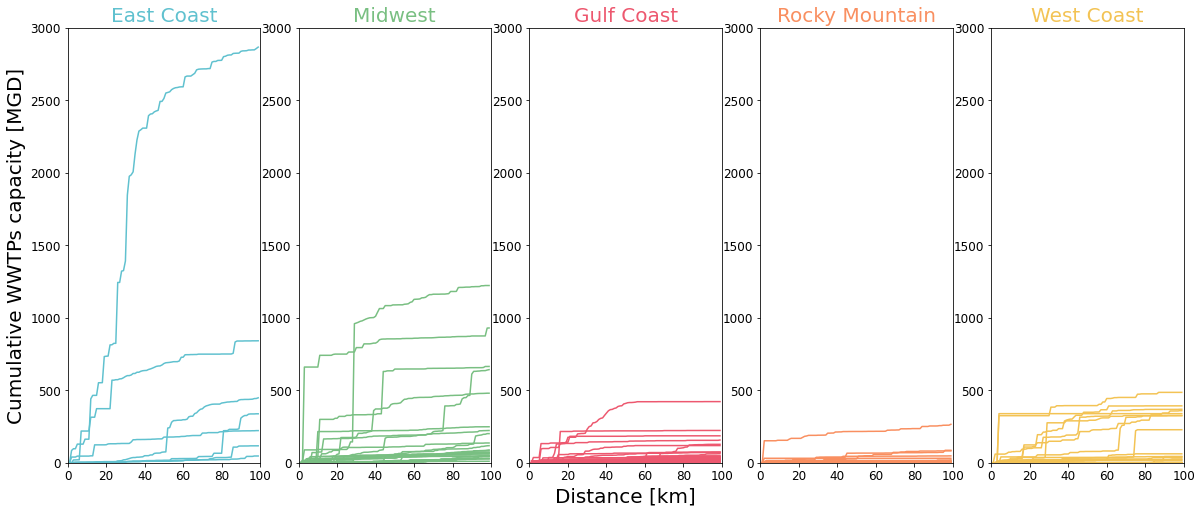

In [15]:
# for every single refinery, plot its cumulative WWTPs capacity as a function of buffering distance
# there will be five plots for five PADD regions and each line represents one refinery
fig, axes = plt.subplots(1, 5, figsize=(20,8))
order = -1
colors = [[0.376,0.757,0.812], # blue
          [0.475,0.749,0.510], # green
          [0.929,0.345,0.435], # red
          [0.976,0.561,0.376], # orange
          [0.953,0.765,0.329]] # yellow
titles = ['East Coast', 'Midwest', 'Gulf Coast', 'Rocky Mountain', 'West Coast']
for region in (PADD_1, PADD_2, PADD_3, PADD_4, PADD_5):
    order += 1
    for i in range(len(region)):
        region.iloc[i,1:100].plot(ax=axes[order], c=colors[order])
    axes[order].set_xlim(0,100)
    axes[order].set_ylim(0,3000)
    axes[order].tick_params(axis='x', labelsize=12)
    axes[order].tick_params(axis='y', labelsize=12)
    if order == 0:
        axes[order].set_ylabel('Cumulative WWTPs capacity [MGD]',fontsize=20)
    if order == 2:
        axes[order].set_xlabel('Distance [km]',fontsize=20)
    
    axes[order].set_title(titles[order], fontdict={'color':colors[order],'size':20})

In [16]:
# select out top 10 refineries that have largest cumulative WWTPs capacities within 100 km
site_id = result[['site_id',100]].sort_values(100, ascending=False).head(10).site_id

<AxesSubplot:>

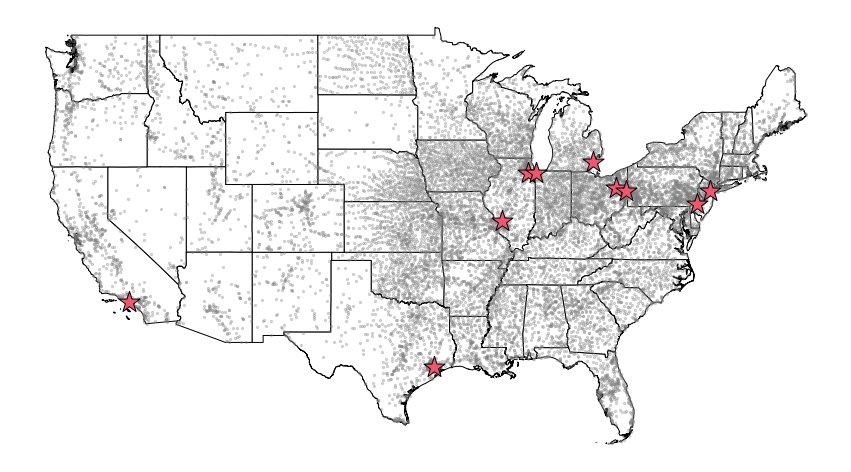

In [17]:
# make a visualization again, but this time, only refineries with the top 10 highest capacities will be shown
fig, ax = plt.subplots(figsize=(15,15))
ax.tick_params(top=False, bottom=False, left=False, right=False,
               labelleft=False, labelbottom=False)
ax.set_frame_on(False)

US.plot(ax=ax, color='w', edgecolor='k')
wwtps.plot(ax=ax, color='gray', alpha=0.3, markersize=5) # WWTPs shown as small gray dots
top_10_refinery = refinery.loc[refinery['site_id'].isin(site_id)]
top_10_refinery.plot(ax=ax, marker='*', color=colors[2], markersize=500, edgecolor='k', linewidth=1) # shown as red star

In [18]:
# get the 100 km cumulative WWTPs capacity of NO.10 refinery
top_10_min = result.sort_values(100, ascending=False).head(10).iloc[-1][100]

In [19]:
# make a folium map that show top 10 refineries in red and others in blue
m = folium.Map(location=[39, -96],zoom_start=4)
for i in range(len(result)):
    color = 'red' if result.iloc[i][100] >= top_10_min else 'blue'
    folium.Marker([result.iloc[i]['Latitude'],result.iloc[i]['Longitude']],
                  popup=folium.Popup(f'''
                                      Company: {result.iloc[i]["Company"]}<br>
                                      Corp: {result.iloc[i]["Corp"]}<br>
                                      State: {result.iloc[i]["State"]}<br>
                                      PADD: {result.iloc[i]["PADD"]}<br>
                                      WWTPs within 100 km: {result.iloc[i][100]:.2f} MGD
                                      ''',
                                     max_width=500),
                  icon = folium.Icon(color = color, icon='industry', prefix='fa'), # use 'industry' icon
                  tooltip='click for more information').add_to(m)
m.save('US_refinery.html') # save the folium map
m